# GRN complex network (gene Suc TF)


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42


/Users/yuanzan/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### network data prepare

In [17]:
grnboost = pd.read_table("../../data/grn/gene_energy_sugar_grnboost2_addtype.csv", sep="\t")
SUC = grnboost .query('TF=="Suc"')
SUC.head(2)

,TF,target,importance,cc,TF_type,target_type
11,Suc,Solyc09g056390.1,75.205480,1,sugar,gene
18,Suc,Solyc04g050040.3,72.598786,1,sugar,gene


In [64]:
c1 = pd.read_excel("gene-TF相关性.xlsx", sheet_name=0, index_col=0)[['r', 'ID']]
c2 = pd.read_excel("gene-TF相关性.xlsx", sheet_name=1, index_col=0)[['r', 'ID']]
c3 = pd.read_excel("gene-TF相关性.xlsx", sheet_name=2, index_col=0)[['r', 'ID']]

c1 = c1[c1["ID"].isin(SUC["target"])==True]
c2 = c2[c2["ID"].isin(SUC["target"])==True]
c3 = c3[c3["ID"].isin(SUC["target"])==True]

def make_graD(df):
    df.columns = ['corr', 'ID']
    df['gene'] = df.index
    df['absR'] = abs(df['corr'])
    df['Sugar'] = 'Suc'
    df['edgeType'] = '-'
    df.loc[df.query('absR<0.6').index, 'edgeType'] = '-.-'
    df['Rlabel'] = round(df['corr'], 2)
    df['gene_r'] = df['gene'] + '\n' + df['Rlabel'].astype(str)
    df.index = df['ID']

    return df

c1 = make_graD(c1)
c2 = make_graD(c2)
c3 = make_graD(c3)


## gene TF corr
gene_TF_corr = pd.read_csv("TF_gene_FPKM_corr.csv", sep="\t")
gene_TF_corr = gene_TF_corr[(gene_TF_corr["Gene"].isin(SUC["target"])==True) & (gene_TF_corr["TF"].isin(SUC["target"])==True)]

gene_TF_corr['Gene_symbol'] = c1.loc[gene_TF_corr['Gene'], "gene"].to_list()
gene_TF_corr['TF_symbol'] = pd.concat([c2, c3], axis=0).loc[gene_TF_corr['TF'], "gene"].to_list()

gene_TF_corr['absR'] = abs(gene_TF_corr['corr'])
gene_TF_corr['edgeType'] = '-'
gene_TF_corr.loc[gene_TF_corr.query('absR<0.6').index, 'edgeType'] = '-.-'
gene_TF_corr['Rlabel'] = round(gene_TF_corr['corr'], 2)
#gene_TF_corr['gene_r'] = gene_TF_corr['gene'] + '\n' + gene_TF_corr['Rlabel'].astype(str)

c2 = c2[c2["gene"].isin(gene_TF_corr["TF_symbol"])]
c3 = c3[c3["gene"].isin(gene_TF_corr["TF_symbol"])]

In [65]:
cols = ['#FBE28F', '#A3B6E7', 
        '#B0B3B7', '#DAC7AE', 
        '#6CB0D2', '#E3ECC2', 
        '#7FA6CD', '#E59386', 
        '#8DA07E', '#7B687E', 
        '#738E89' , '#A97D75', 
        '#85B8B4' , '#F2B0D2']

TF_family = ['ERF', 'MYB', 'NAC', 'WRKY', 'B3', 'HLH', 'HSF', 'TCP', 'Trihelix', 'VOZ', 'ZIP']
TF_cols = pd.DataFrame(TF_family)
TF_cols.columns = ['TFFs']
TF_cols.index = TF_cols['TFFs']
TF_cols['color'] = None

for i,v in enumerate(TF_family):
    TF_cols.loc[v, "color"] = cols[i]

TF_cols.index.name = 'ID'
TF_cols = TF_cols.sort_values(['TFFs'])
    
    
#gene_TF_corr

# network style 1

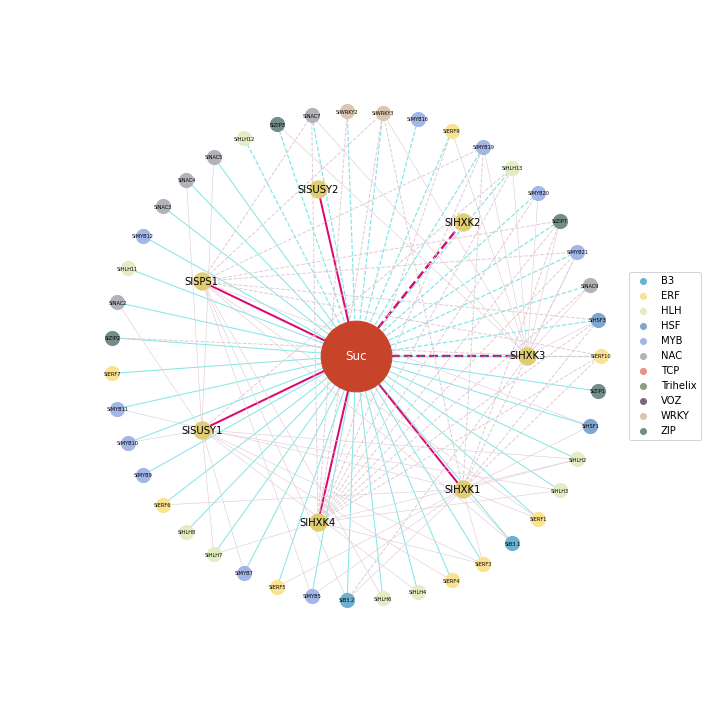

In [66]:
def get_nodes(df, scale=1):
    G = nx.cycle_graph(df.shape[0])
    pos = nx.circular_layout(G, scale=scale)
    pos = {df['gene'].to_list()[i]:pos[i] for i in pos}

    return G, pos
    
plt.figure(1, figsize=(10, 10))

mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42


G1, pos1 = get_nodes(c1.sort_values(['corr']), scale=7)

c23 = pd.concat([c2, c3], axis=0)


c23['TFfamily'] = None

for i,row in TF_cols.iterrows():
    c23.loc[c23[c23['gene'].str.contains(row['TFFs'])].index, "TFfamily"] = row['TFFs']
    
c23['TFcolor'] = TF_cols.loc[c23['TFfamily'], 'color'].to_list()
c23 = c23.sort_values(['corr', 'TFfamily'])




G23, pos23 = get_nodes(c23, scale=10)




G = nx.Graph()
G.clear()

for i in c1['gene'].to_list():
    G.add_node(i)

for i in c23['gene'].to_list():
    G.add_node(i, )

G.add_node("Suc")

pos = dict(pos1, **pos23)
pos['Suc'] = np.array([0,0])
    
    

    
    
nx.draw_networkx_nodes(G, {'Suc': pos['Suc']}, nodelist=['Suc'], node_size=5000, node_color='#C7442A')
nx.draw_networkx_nodes(G, pos1, nodelist=c1['gene'].to_list(), node_size=300, node_color='#E0CC71')


for i in c23['TFfamily'].unique():
    nx.draw_networkx_nodes(G, pos23, nodelist=c23[c23['TFfamily']==i]['gene'].to_list(), node_size=200, node_color=TF_cols.loc[i, 'color'])


nx.draw_networkx_labels(G, {'Suc': pos['Suc']}, labels={'Suc': 'Suc'}, font_size=12, font_family="sans-serif", font_color='w')


nx.draw_networkx_labels(G, pos1, labels={i:i for i in pos1}, font_size=10, font_family="sans-serif", font_color='k')
nx.draw_networkx_labels(G, pos23, labels={i:i for i in pos23}, font_size=5, font_family="sans-serif", font_color='k')




def draw_edge(df, G, pos, edge_color='#E00671', width=5, alpha=1):
    # add edges
    #c_edges = []
    c_edges_pos = []
    c_edges_neg = []
    for i,row in df.iterrows():
        G.add_edge(row['gene'], row['Sugar'], length=row['absR'], weight=row['corr'])
        #c_edges.append((row['gene'], row['Sugar']))
        if row['corr'] > 0:
            c_edges_pos.append((row['gene'], row['Sugar']))
        else:
            c_edges_neg.append((row['gene'], row['Sugar']))
        
    
    nx.draw_networkx_edges(G, pos, edgelist=c_edges_pos, edge_color=edge_color, width=width, alpha=alpha, style = 'solid')
    nx.draw_networkx_edges(G, pos, edgelist=c_edges_neg, edge_color=edge_color, width=width*1.2, alpha=alpha, style = 'dashed')

draw_edge(c1, G, pos, edge_color='#E00671', width=2)
draw_edge(c23, G, pos, edge_color='#07CCD2', width=1, alpha=0.5)


#gene_TF_edges = []
gene_TF_edges_pos = []
gene_TF_edges_neg = []

for i,row in gene_TF_corr.query('absR>0.6').iterrows():
    G.add_edge(row['Gene_symbol'], row['TF_symbol'], length=row['absR'], weight=row['corr'])
    #gene_TF_edges.append((row['Gene_symbol'], row['TF_symbol']))
    if row['corr'] > 0:
        gene_TF_edges_pos.append((row['Gene_symbol'], row['TF_symbol']))
    else:
        gene_TF_edges_neg.append((row['Gene_symbol'], row['TF_symbol']))
    

nx.draw_networkx_edges(G, pos, edgelist=gene_TF_edges_pos, edge_color='#E0CCD2',  width=0.6, alpha=1, )
nx.draw_networkx_edges(G, pos, edgelist=gene_TF_edges_neg, edge_color='#E0CCD2',  width=1, alpha=1, style="dashed")



ax = plt.gca()

for i, row in TF_cols.iterrows():
    ax.scatter(None,None, label=row['TFFs'], color=row['color'])
    
ax.legend(loc=5)

ax.margins(0.15)
plt.axis("off")
plt.tight_layout()


#plt.savefig("GRN_Suc_multi_circle_network_style.pdf")



# network style2

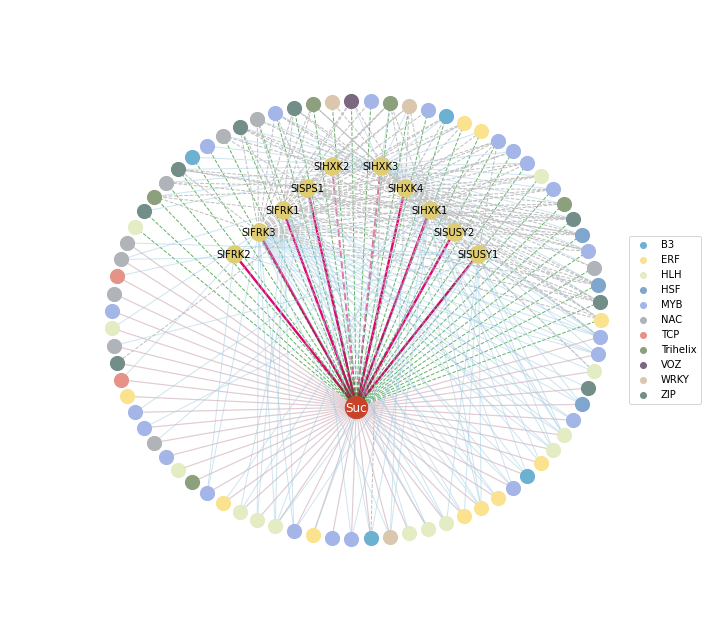

In [10]:
import bezier
from matplotlib.collections import LineCollection
import random

def curved_graph(graph, pos = None, eps=0.2, pointn=30):

    if pos == None:
        pos = nx.spring_layout(graph)

    for u,v in graph.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        segs = curved_line(x0,y0,x1,y1)
        lc = LineCollection(segs)
        plt.gca().add_collection(lc)
        plt.gca().autoscale_view()

def curved_line(x0, y0, x1, y1, eps=0.2, pointn=30):

    x2 = (x0+x1)/2.0 + 0.1 ** (eps+abs(x0-x1)) * (-1) ** (random.randint(1,4))
    y2 = (y0+y1)/2.0 + 0.1 ** (eps+abs(y0-y1)) * (-1) ** (random.randint(1,4))
    nodes = np.asfortranarray([
        [x0, x2, x1],
        [y0, y2, y1]
    ])
    curve = bezier.Curve(nodes,
                         degree=2)
    s_vals = np.linspace(0.0, 1.0, pointn)
    data=curve.evaluate_multi(s_vals)
    x=data[0]
    y=data[1]
    segments =[]
    for index in range(0,len(x)):
        segments.append([x[index],y[index]])
    segments = [segments]
    return  segments

def get_nodes(df, scale=1, center=np.array([0,0])):
    G = nx.cycle_graph(df.shape[0])
    pos = nx.circular_layout(G, scale=scale, center=center)
    pos = {df['gene'].to_list()[i]:pos[i] for i in pos}

    return G, pos
    
plt.figure(1, figsize=(10, 9))



c23 = pd.concat([c2, c3], axis=0)


c23['TFfamily'] = None

for i,row in TF_cols.iterrows():
    c23.loc[c23[c23['gene'].str.contains(row['TFFs'])].index, "TFfamily"] = row['TFFs']
    
c23['TFcolor'] = TF_cols.loc[c23['TFfamily'], 'color'].to_list()
c23 = c23.sort_values(['corr', 'TFfamily'])



G1, pos1 = get_nodes(c1, scale=2, center=np.array([0,0]))
G23, pos23 = get_nodes(c23, scale=10, center=np.array([0,0]))




G = nx.Graph()
G.clear()

for i in c1['gene'].to_list():
    G.add_node(i)

for i in c23['gene'].to_list():
    G.add_node(i, )

G.add_node("Suc")


pos1_x = [5,4,3,2,1,-1,-2,-3,-4,-5]
pos1_y = [3,4,5,6,7,7,6,5,4,3]
pos1 = {v:np.array([pos1_x[i], pos1_y[i]]) for i,v in enumerate(c1['gene'].to_list())}

pos = dict(pos1, **pos23)
pos['Suc'] = np.array([0,-4])
    

nx.draw_networkx_nodes(G, {'Suc': pos['Suc']}, nodelist=['Suc'], node_size=500, node_color='#C7442A')
nx.draw_networkx_nodes(G, pos1, nodelist=c1['gene'].to_list(), node_size=300, node_color='#E0CC71')


for i in c23['TFfamily'].unique():
    nx.draw_networkx_nodes(G, pos23, nodelist=c23[c23['TFfamily']==i]['gene'].to_list(), node_size=200, node_color=TF_cols.loc[i, 'color'])


nx.draw_networkx_labels(G, {'Suc': pos['Suc']}, labels={'Suc': 'Suc'}, font_size=12, font_family="sans-serif", font_color='w')


nx.draw_networkx_labels(G, pos1, labels={i:i for i in pos1}, font_size=10, font_family="sans-serif", font_color='k')
#nx.draw_networkx_labels(G, pos23, labels={i:i for i in pos23}, font_size=6, font_family="sans-serif", font_color='k')




def draw_edge(df, G, pos, pos_edge_color='#E00671', neg_edge_color='#E00671', width=5, alpha=1):
    # add edges
    #c_edges = []
    c_edges_pos = []
    c_edges_neg = []
    for i,row in df.iterrows():
        G.add_edge(row['gene'], row['Sugar'], length=row['absR'], weight=row['corr'])
        #c_edges.append((row['gene'], row['Sugar']))
        if row['corr'] > 0:
            c_edges_pos.append((row['gene'], row['Sugar']))
        else:
            c_edges_neg.append((row['gene'], row['Sugar']))
        
    
    nx.draw_networkx_edges(G, pos, edgelist=c_edges_pos, edge_color=pos_edge_color, width=width*1.2, alpha=1, style = 'solid')
    nx.draw_networkx_edges(G, pos, edgelist=c_edges_neg, edge_color=neg_edge_color, width=width, alpha=0.6, style = 'dashed')

draw_edge(c1, G, pos, pos_edge_color='#E00671', neg_edge_color='#E00671', width=2)
draw_edge(c23, G, pos, pos_edge_color='#E0CCD2', neg_edge_color='g', width=1, alpha=0.5)


#gene_TF_edges = []
gene_TF_edges_pos = []
gene_TF_edges_neg = []

for i,row in gene_TF_corr.query('absR>0.6').iterrows():
    G.add_edge(row['Gene_symbol'], row['TF_symbol'], length=row['absR'], weight=row['corr'])
    #gene_TF_edges.append((row['Gene_symbol'], row['TF_symbol']))
    if row['corr'] > 0:
        gene_TF_edges_pos.append((row['Gene_symbol'], row['TF_symbol']))
    else:
        gene_TF_edges_neg.append((row['Gene_symbol'], row['TF_symbol']))
    

nx.draw_networkx_edges(G, pos, edgelist=gene_TF_edges_pos, edge_color='#A0CBE2',  width=1, alpha=0.5 )
nx.draw_networkx_edges(G, pos, edgelist=gene_TF_edges_neg, edge_color='silver',  width=1, alpha=1, style="dashed")


#curved_graph(G,pos)

ax = plt.gca()

for i, row in TF_cols.iterrows():
    ax.scatter(None,None, label=row['TFFs'], color=row['color'])

ax.legend(loc=5)

ax.margins(0.15)
plt.axis("off")
plt.tight_layout()


#plt.savefig("multi_circle_network_style3.pdf")

